In [1]:
using Pkg
Pkg.activate("./../")

using Oceananigans, ChannelSimulations, GLMakie

  Activating project at `~/development/ChannelSimulations.jl`
Precompiling packages...
    555.4 ms  ✓ Revise → DistributedExt
  1 dependency successfully precompiled in 1 seconds. 7 already precompiled.
[ Info: Precompiling GLMakie [e9467ef8-e4e7-5192-8a1a-b1aee30e663a]
[ Info: Precompiling SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]
[ Info: Precompiling ChainRulesCoreExt [eae2faf6-b232-58cb-a410-7764fda2830c]
[ Info: Precompiling OceananigansMakieExt [8b7e02c2-18e1-5ade-af7b-cfb5875075c8]


In [2]:
using Statistics: mean

function get_dissipation(filename)
    Abxt = FieldTimeSeries(filename, "Abx")
    Abyt = FieldTimeSeries(filename, "Aby")
    Abzt = FieldTimeSeries(filename, "Abz")
    Gbxt = FieldTimeSeries(filename, "Gbx")
    Gbyt = FieldTimeSeries(filename, "Gby")
    Gbzt = FieldTimeSeries(filename, "Gbz")
    Dbzt = FieldTimeSeries(filename, "Dbz")

    grid  = Abxt.grid
    times = Abxt.times
    Nx, Ny, Nz = size(grid)    
    VFCC = KernelFunctionOperation{Face, Center, Center}(Oceananigans.Operators.Vᶠᶜᶜ, grid)
    VCFC = KernelFunctionOperation{Center, Face, Center}(Oceananigans.Operators.Vᶜᶠᶜ, grid)
    VCCF = KernelFunctionOperation{Center, Center, Face}(Oceananigans.Operators.Vᶜᶜᶠ, grid)

    VFCC = compute!(Field(VFCC))
    VCFC = compute!(Field(VCFC))
    VCCF = compute!(Field(VCCF))
    
    Abx = FieldTimeSeries{Nothing, Center, Center}(grid, times)
    Aby = FieldTimeSeries{Nothing, Face,   Center}(grid, times)
    Abz = FieldTimeSeries{Nothing, Center, Face}(grid, times)
    Gbx = FieldTimeSeries{Nothing, Center, Center}(grid, times)
    Gby = FieldTimeSeries{Nothing, Face,   Center}(grid, times)
    Gbz = FieldTimeSeries{Nothing, Center, Face}(grid, times)
    Dbz = FieldTimeSeries{Nothing, Center, Face}(grid, times)

    for t in eachindex(times)
        set!(Abx[t], mean(Abxt[t], dims=1))
        set!(Aby[t], mean(Abyt[t], dims=1))
        set!(Abz[t], mean(Abzt[t], dims=1))
        set!(Gbx[t], mean(Gbxt[t] * VFCC, dims=1))
        set!(Gby[t], mean(Gbyt[t] * VCFC, dims=1))
        interior(Gby[t], :, 1, :) .= interior(Gby[t], :, 2, :) 
        interior(Gby[t], :, Ny+1, :) .= interior(Gby[t], :, Ny, :) 
        set!(Gbz[t], mean(Gbzt[t] * VCCF, dims=1))
        set!(Dbz[t], mean(Dbzt[t], dims=1))
    end
    
    return (; Abx, Aby, Abz, Gbx, Gby, Gbz, Dbz)
end

get_dissipation (generic function with 1 method)

In [16]:
dauCA = get_dissipation("../averages_00300.jld2");
dawCA = get_dissipation("../averages_01010.jld2");
drwCA = get_dissipation("../averages_00010.jld2");

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]


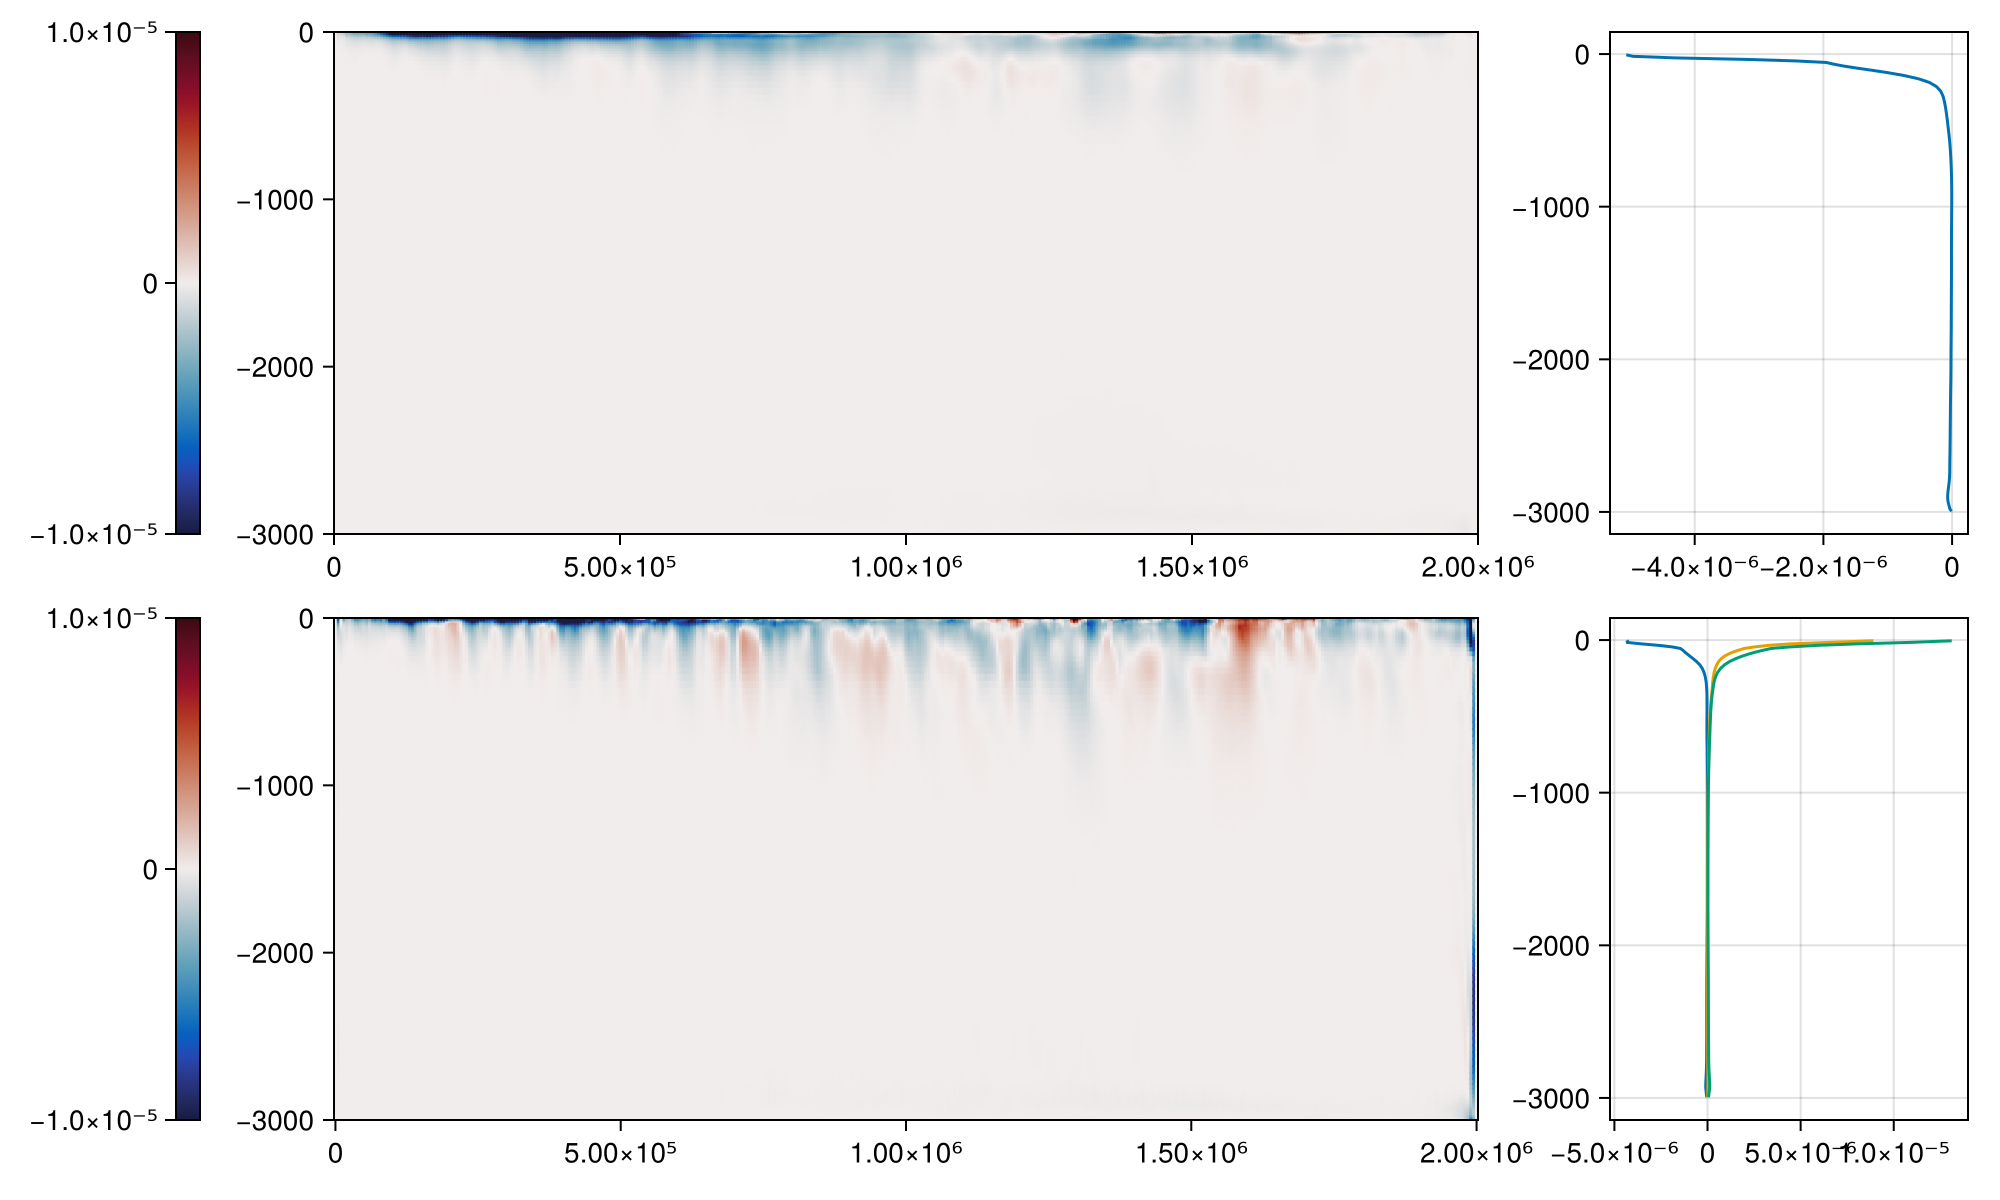

CairoMakie.Screen{IMAGE}


In [4]:
using CairoMakie
fig = Figure(size = (1000, 600))
ax = Axis(fig[1, 1:3])
hm = heatmap!(- dawCA.Abx[end] + drwCA.Abx[end], colormap=:balance, colorrange = (-1e-5, 1e-5))
Colorbar(fig[1, 0], hm, flipaxis=false)
ax = Axis(fig[1, 4])
lines!(ax, mean(- dawCA.Abx[end] + drwCA.Abx[end], dims=2))
ax = Axis(fig[2, 1:3])
hm = heatmap!(- dawCA.Aby[end] + drwCA.Aby[end], colormap=:balance, colorrange = (-1e-5, 1e-5))
Colorbar(fig[2, 0], hm, flipaxis=false)
ax = Axis(fig[2, 4])
lines!(ax, mean(- dawCA.Aby[end] + drwCA.Aby[end], dims=2))
lines!(ax, mean(- dawCA.Aby[end], dims=2))
lines!(ax, mean(- drwCA.Aby[end], dims=2))
display(current_figure())

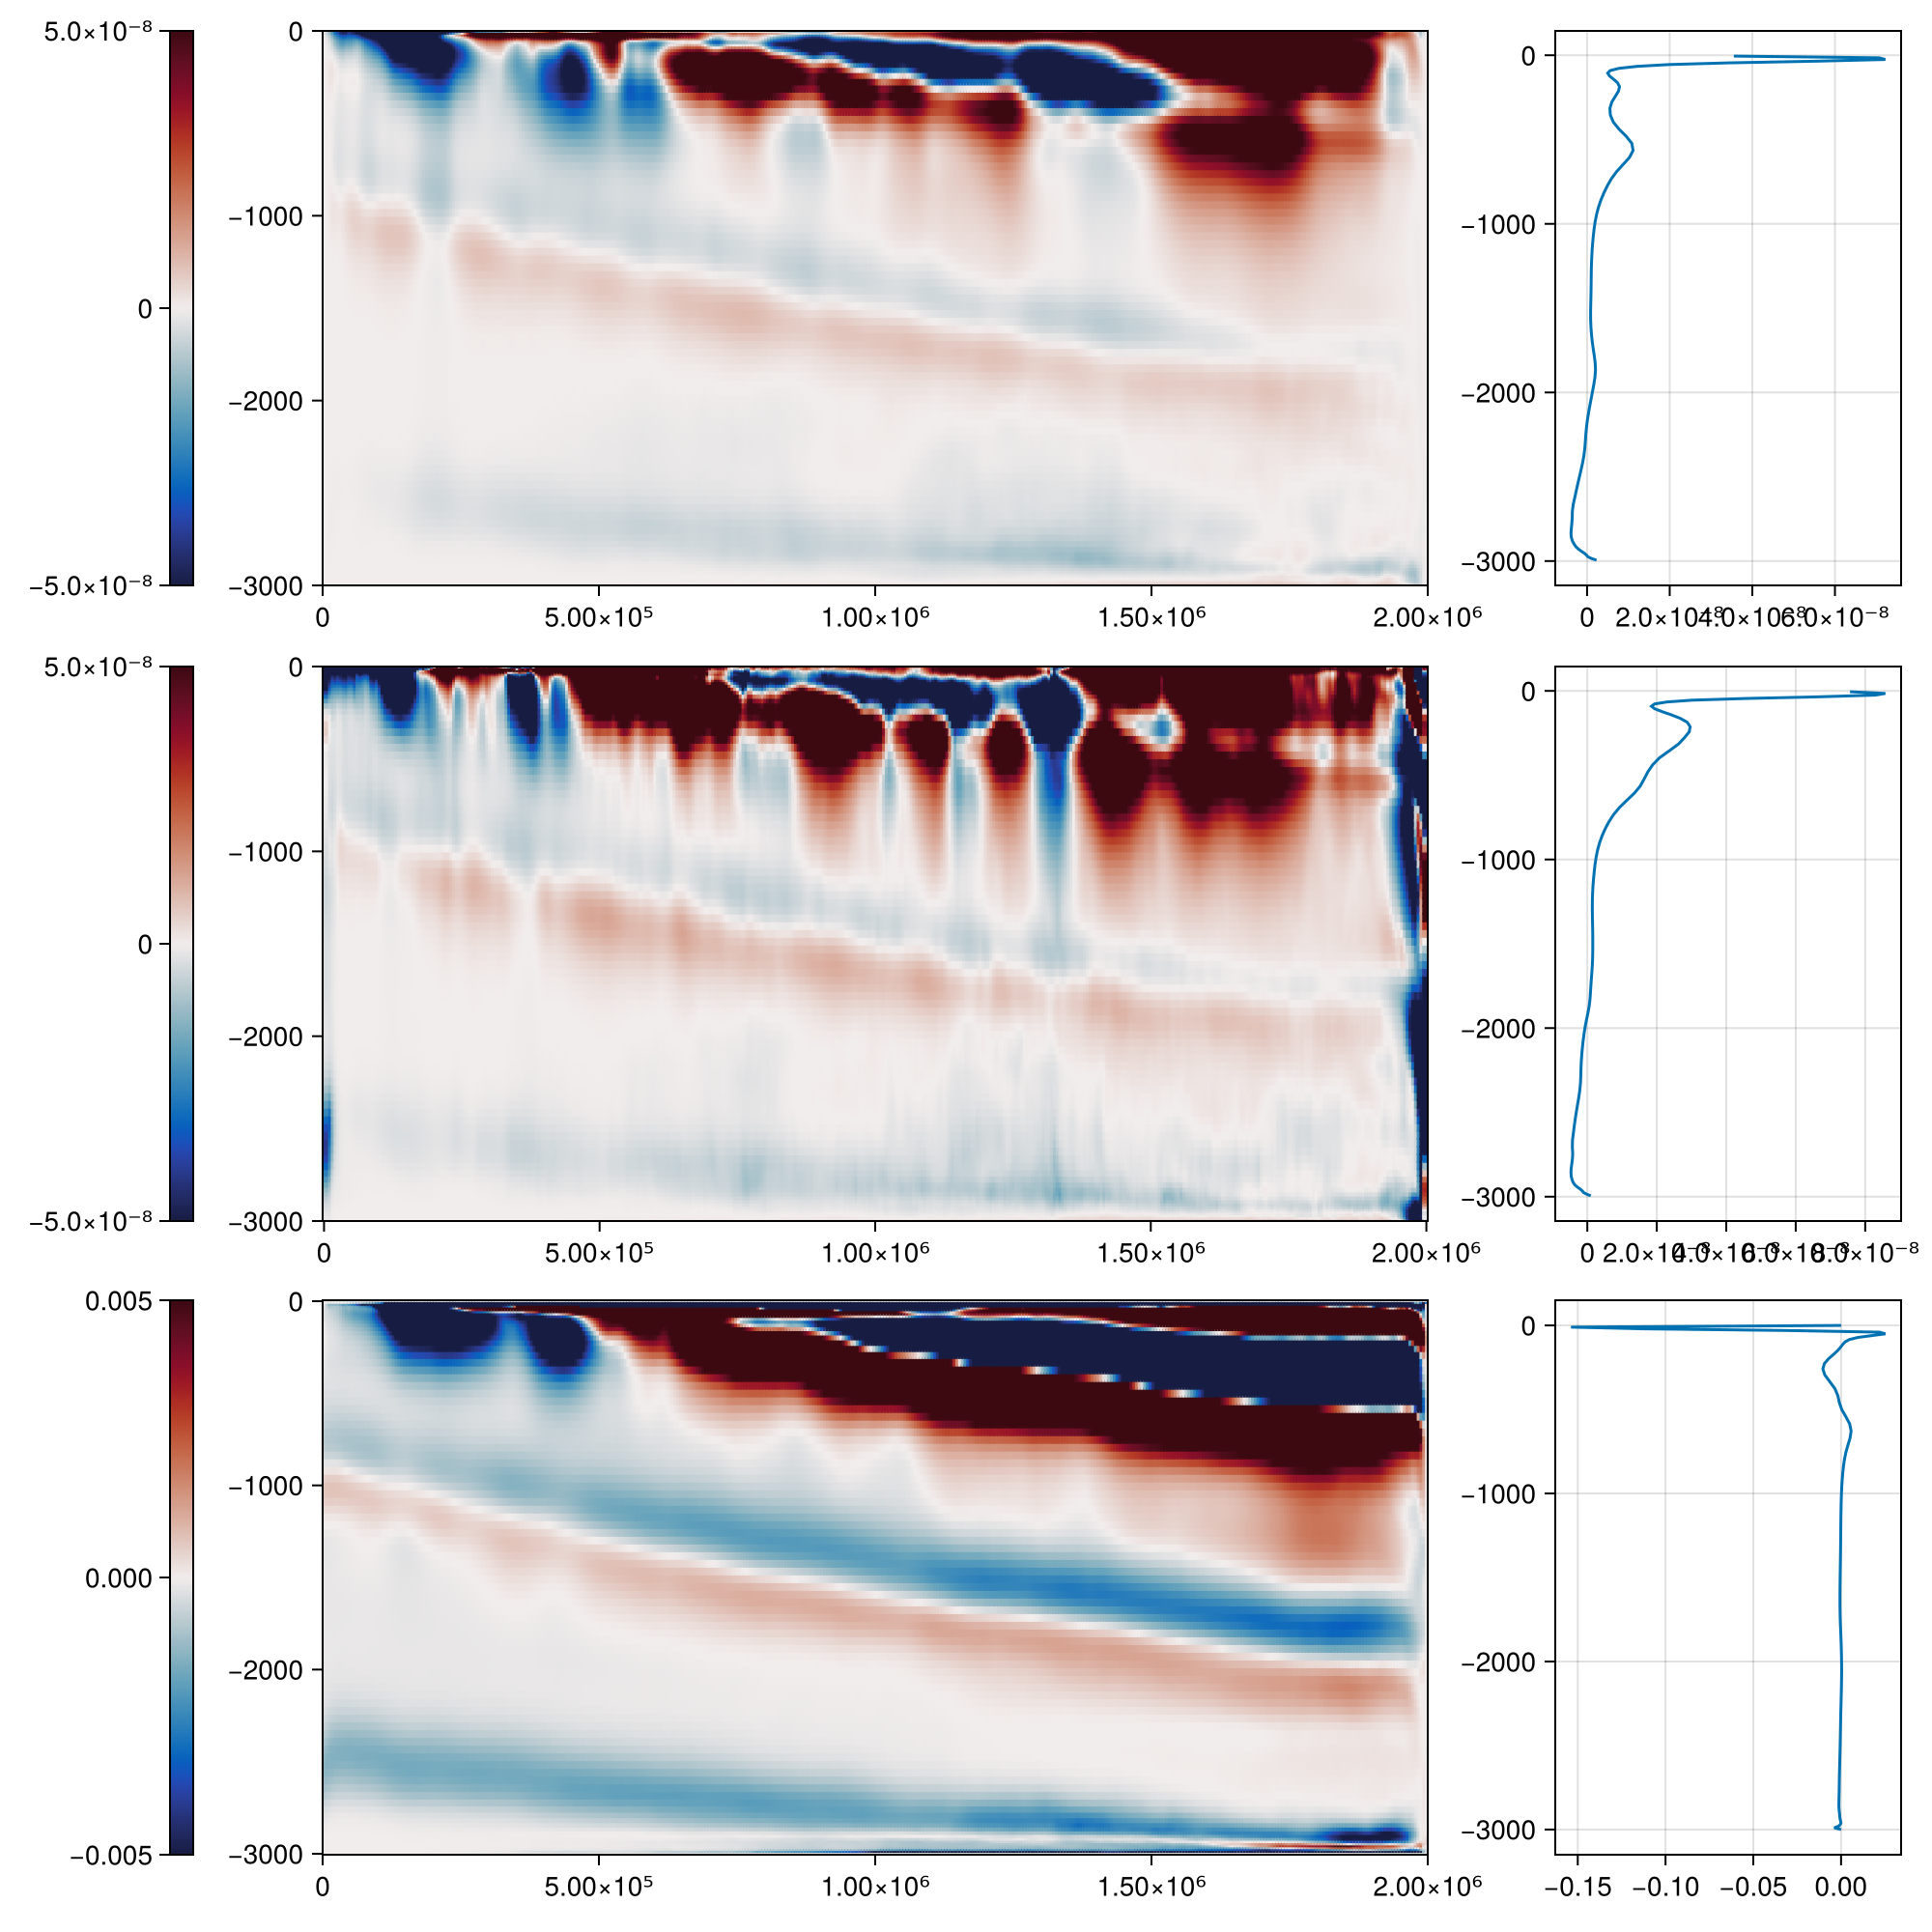

CairoMakie.Screen{IMAGE}


In [23]:
using CairoMakie
fig = Figure(size = (1000, 1000))
ax = Axis(fig[1, 1:3])
hm = heatmap!(dawCA.Gbx[end] - drwCA.Gbx[end], colormap=:balance, colorrange = (-5e-8, 5e-8))
Colorbar(fig[1, 0], hm, flipaxis=false)
ax = Axis(fig[1, 4])
lines!(ax, mean(dawCA.Gbx[end] - drwCA.Gbx[end], dims=2))
ax = Axis(fig[2, 1:3])
hm = heatmap!(dawCA.Gby[end] - drwCA.Gby[end], colormap=:balance, colorrange = (-5e-8, 5e-8))
Colorbar(fig[2, 0], hm, flipaxis=false)
ax = Axis(fig[2, 4])
lines!(ax, mean(dawCA.Gby[end] - drwCA.Gby[end], dims=2))
ax = Axis(fig[3, 1:3])
hm = heatmap!(dawCA.Gbz[end] - drwCA.Gbz[end], colormap=:balance, colorrange = (-5e-3, 5e-3))
Colorbar(fig[3, 0], hm, flipaxis=false)
ax = Axis(fig[3, 4])
lines!(ax, mean(dawCA.Gbz[end] - drwCA.Gbz[end], dims=2))
display(current_figure())

In [17]:
κxau = mean(- dauCA.Abx[end], dims = 2) / mean(dauCA.Gbx[end], dims = 2) / 2
κyau = mean(- dauCA.Aby[end], dims = 2) / mean(dauCA.Gby[end], dims = 2) / 2
κzau = mean(- dauCA.Abz[end], dims = 2) / mean(dauCA.Gbz[end], dims = 2) / 2
κxaw = mean(- dawCA.Abx[end], dims = 2) / mean(dawCA.Gbx[end], dims = 2) / 2
κyaw = mean(- dawCA.Aby[end], dims = 2) / mean(dawCA.Gby[end], dims = 2) / 2
κzaw = mean(- dawCA.Abz[end], dims = 2) / mean(dawCA.Gbz[end], dims = 2) / 2
κxrw = mean(- drwCA.Abx[end], dims = 2) / mean(drwCA.Gbx[end], dims = 2) / 2
κyrw = mean(- drwCA.Aby[end], dims = 2) / mean(drwCA.Gby[end], dims = 2) / 2
κzrw = mean(- drwCA.Abz[end], dims = 2) / mean(drwCA.Gbz[end], dims = 2) / 2

sGau = dauCA.Gbx[end] + dauCA.Gby[end] + dauCA.Gbz[end]
sGaw = dawCA.Gbx[end] + dawCA.Gby[end] + dawCA.Gbz[end]
sGrw = drwCA.Gbx[end] + drwCA.Gby[end] + drwCA.Gbz[end]

κxzau = mean(- dauCA.Abx[end], dims = 2) / mean(sGau, dims = 2) / 2
κyzau = mean(- dauCA.Aby[end], dims = 2) / mean(sGau, dims = 2) / 2
κzzau = mean(- dauCA.Abz[end], dims = 2) / mean(sGau, dims = 2) / 2
κxzaw = mean(- dawCA.Abx[end], dims = 2) / mean(sGaw, dims = 2) / 2
κyzaw = mean(- dawCA.Aby[end], dims = 2) / mean(sGaw, dims = 2) / 2
κzzaw = mean(- dawCA.Abz[end], dims = 2) / mean(sGaw, dims = 2) / 2
κxzrw = mean(- drwCA.Abx[end], dims = 2) / mean(sGrw, dims = 2) / 2
κyzrw = mean(- drwCA.Aby[end], dims = 2) / mean(sGrw, dims = 2) / 2
κzzrw = mean(- drwCA.Abz[end], dims = 2) / mean(sGrw, dims = 2) / 2

BinaryOperation at (⋅, ⋅, Face)
├── grid: 200×400×90 RectilinearGrid{Float64, Periodic, Bounded, Bounded} on CPU with 6×6×6 halo
└── tree: 
    / at (⋅, ⋅, Face)
    ├── / at (⋅, ⋅, Face)
    │   ├── 1×1×91 Field{Nothing, Nothing, Face} reduced over dims = (1, 2) on RectilinearGrid on CPU
    │   └── 1×1×90 Field{Nothing, Nothing, Center} reduced over dims = (1, 2) on RectilinearGrid on CPU
    └── 2

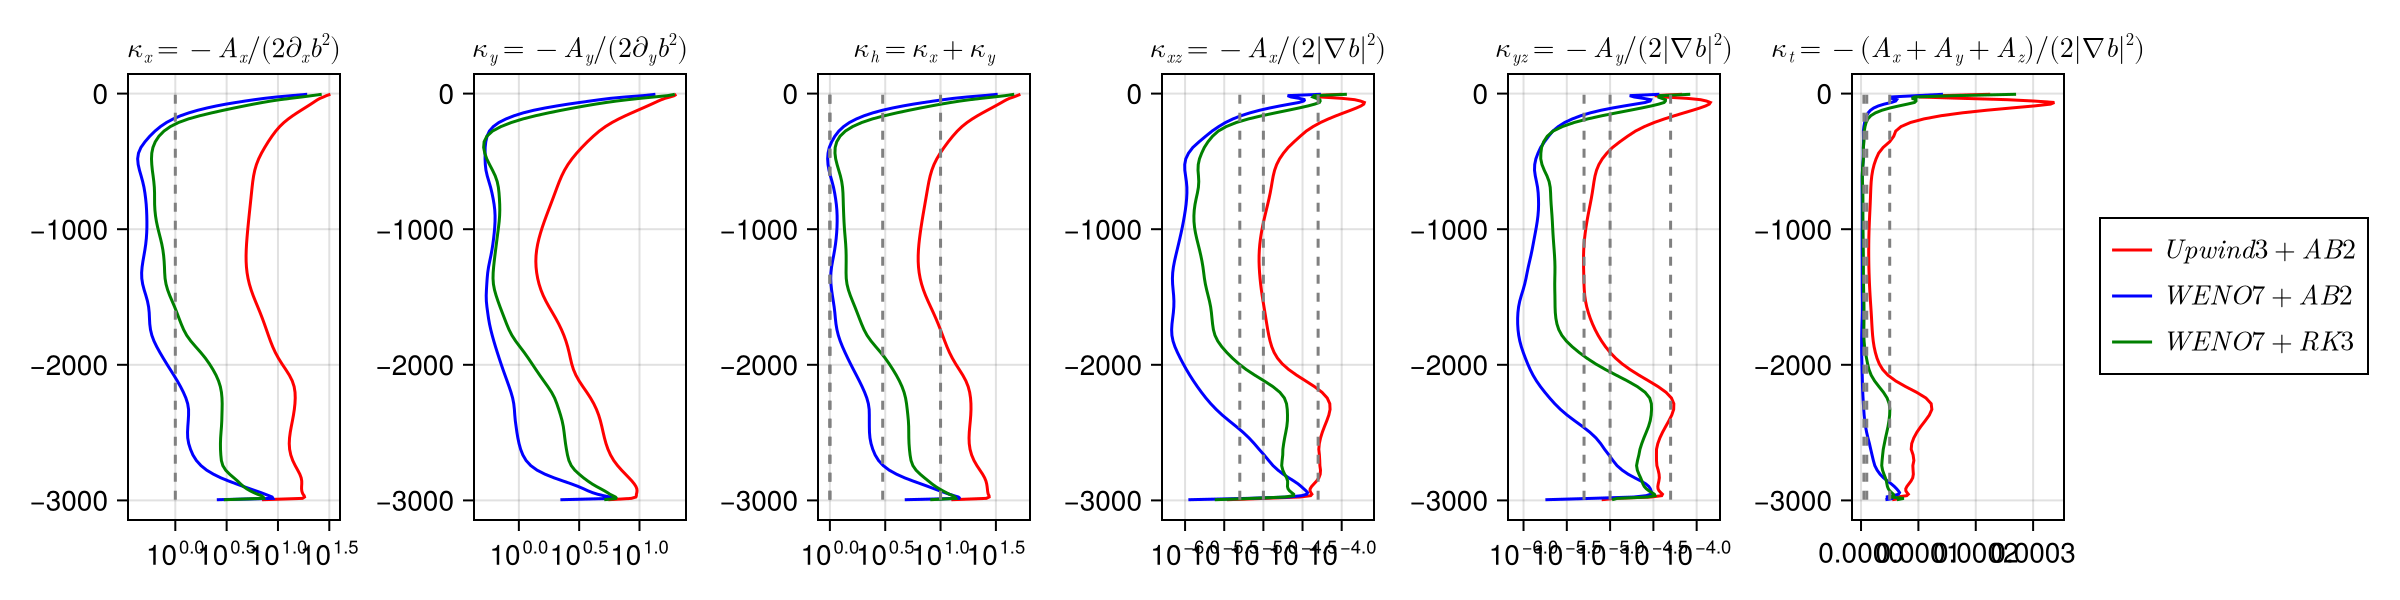

CairoMakie.Screen{IMAGE}


In [20]:
fig = Figure(size = (1200, 300))
ax = Axis(fig[1, 1], xscale = log10, title = L"\kappa_x = - A_x / (2\partial_x b^2)")
lines!(ax, κxau, color=:red)
lines!(ax, κxaw, color=:blue)
lines!(ax, κxrw, color=:green)
lines!(ax, κyzaw / κyzaw, color=:grey, linestyle=:dash)
ax = Axis(fig[1, 2], xscale = log10, title = L"\kappa_y = - A_y / (2\partial_y b^2)")
lines!(ax, κyau, color=:red)
lines!(ax, κyaw, color=:blue)
lines!(ax, κyrw, color=:green)
ax = Axis(fig[1, 3], xscale=log10, title = L"\kappa_h = \kappa_x + \kappa_y")
lines!(ax, (κxau + κyau), color=:red)
lines!(ax, (κxaw + κyaw), color=:blue)
lines!(ax, (κxrw + κyrw), color=:green)
lines!(ax, κyzaw / κyzaw * 01.0, color=:grey, linestyle=:dash)
lines!(ax, κyzaw / κyzaw * 03.0, color=:grey, linestyle=:dash)
lines!(ax, κyzaw / κyzaw * 10.0, color=:grey, linestyle=:dash)
lines!(ax, κyzaw / κyzaw, color=:grey, linestyle=:dash)
ax = Axis(fig[1, 4], xscale = log10, title = L"\kappa_{xz} = - A_x / (2 |\nabla b|^2)")
lines!(ax, κxzau, color=:red)
lines!(ax, κxzaw, color=:blue)
lines!(ax, κxzrw, color=:green)
lines!(ax, κyzaw / κyzaw * 5e-5, color=:grey, linestyle=:dash)
lines!(ax, κyzaw / κyzaw * 1e-5, color=:grey, linestyle=:dash)
lines!(ax, κyzaw / κyzaw * 5e-6, color=:grey, linestyle=:dash)
ax = Axis(fig[1, 5], xscale = log10, title = L"\kappa_{yz} = - A_y / (2 |\nabla b|^2)")
lines!(ax, κyzau, color=:red)
lines!(ax, κyzaw, color=:blue)
lines!(ax, κyzrw, color=:green)
lines!(ax, κyzaw / κyzaw * 5e-5, color=:grey, linestyle=:dash)
lines!(ax, κyzaw / κyzaw * 1e-5, color=:grey, linestyle=:dash) 
lines!(ax, κyzaw / κyzaw * 5e-6, color=:grey, linestyle=:dash)
ax = Axis(fig[1, 6], title = L"\kappa_t = - (A_x + A_y + A_z) / (2 |\nabla b|^2)") #, xscale=log10)
lines!(ax, (κxzau + κyzau + κzzau), color=:red,   label=L"Upwind 3 + AB2")
lines!(ax, (κxzaw + κyzaw + κzzaw), color=:blue,  label=L"WENO 7 + AB2")
lines!(ax, (κxzrw + κyzrw + κzzrw), color=:green, label=L"WENO 7 + RK3")
lines!(ax, κyzaw / κyzaw * 5e-5, color=:grey, linestyle=:dash)
lines!(ax, κyzaw / κyzaw * 1e-5, color=:grey, linestyle=:dash)
lines!(ax, κyzaw / κyzaw * 5e-6, color=:grey, linestyle=:dash)
Legend(fig[1, 7], ax)
display(fig)

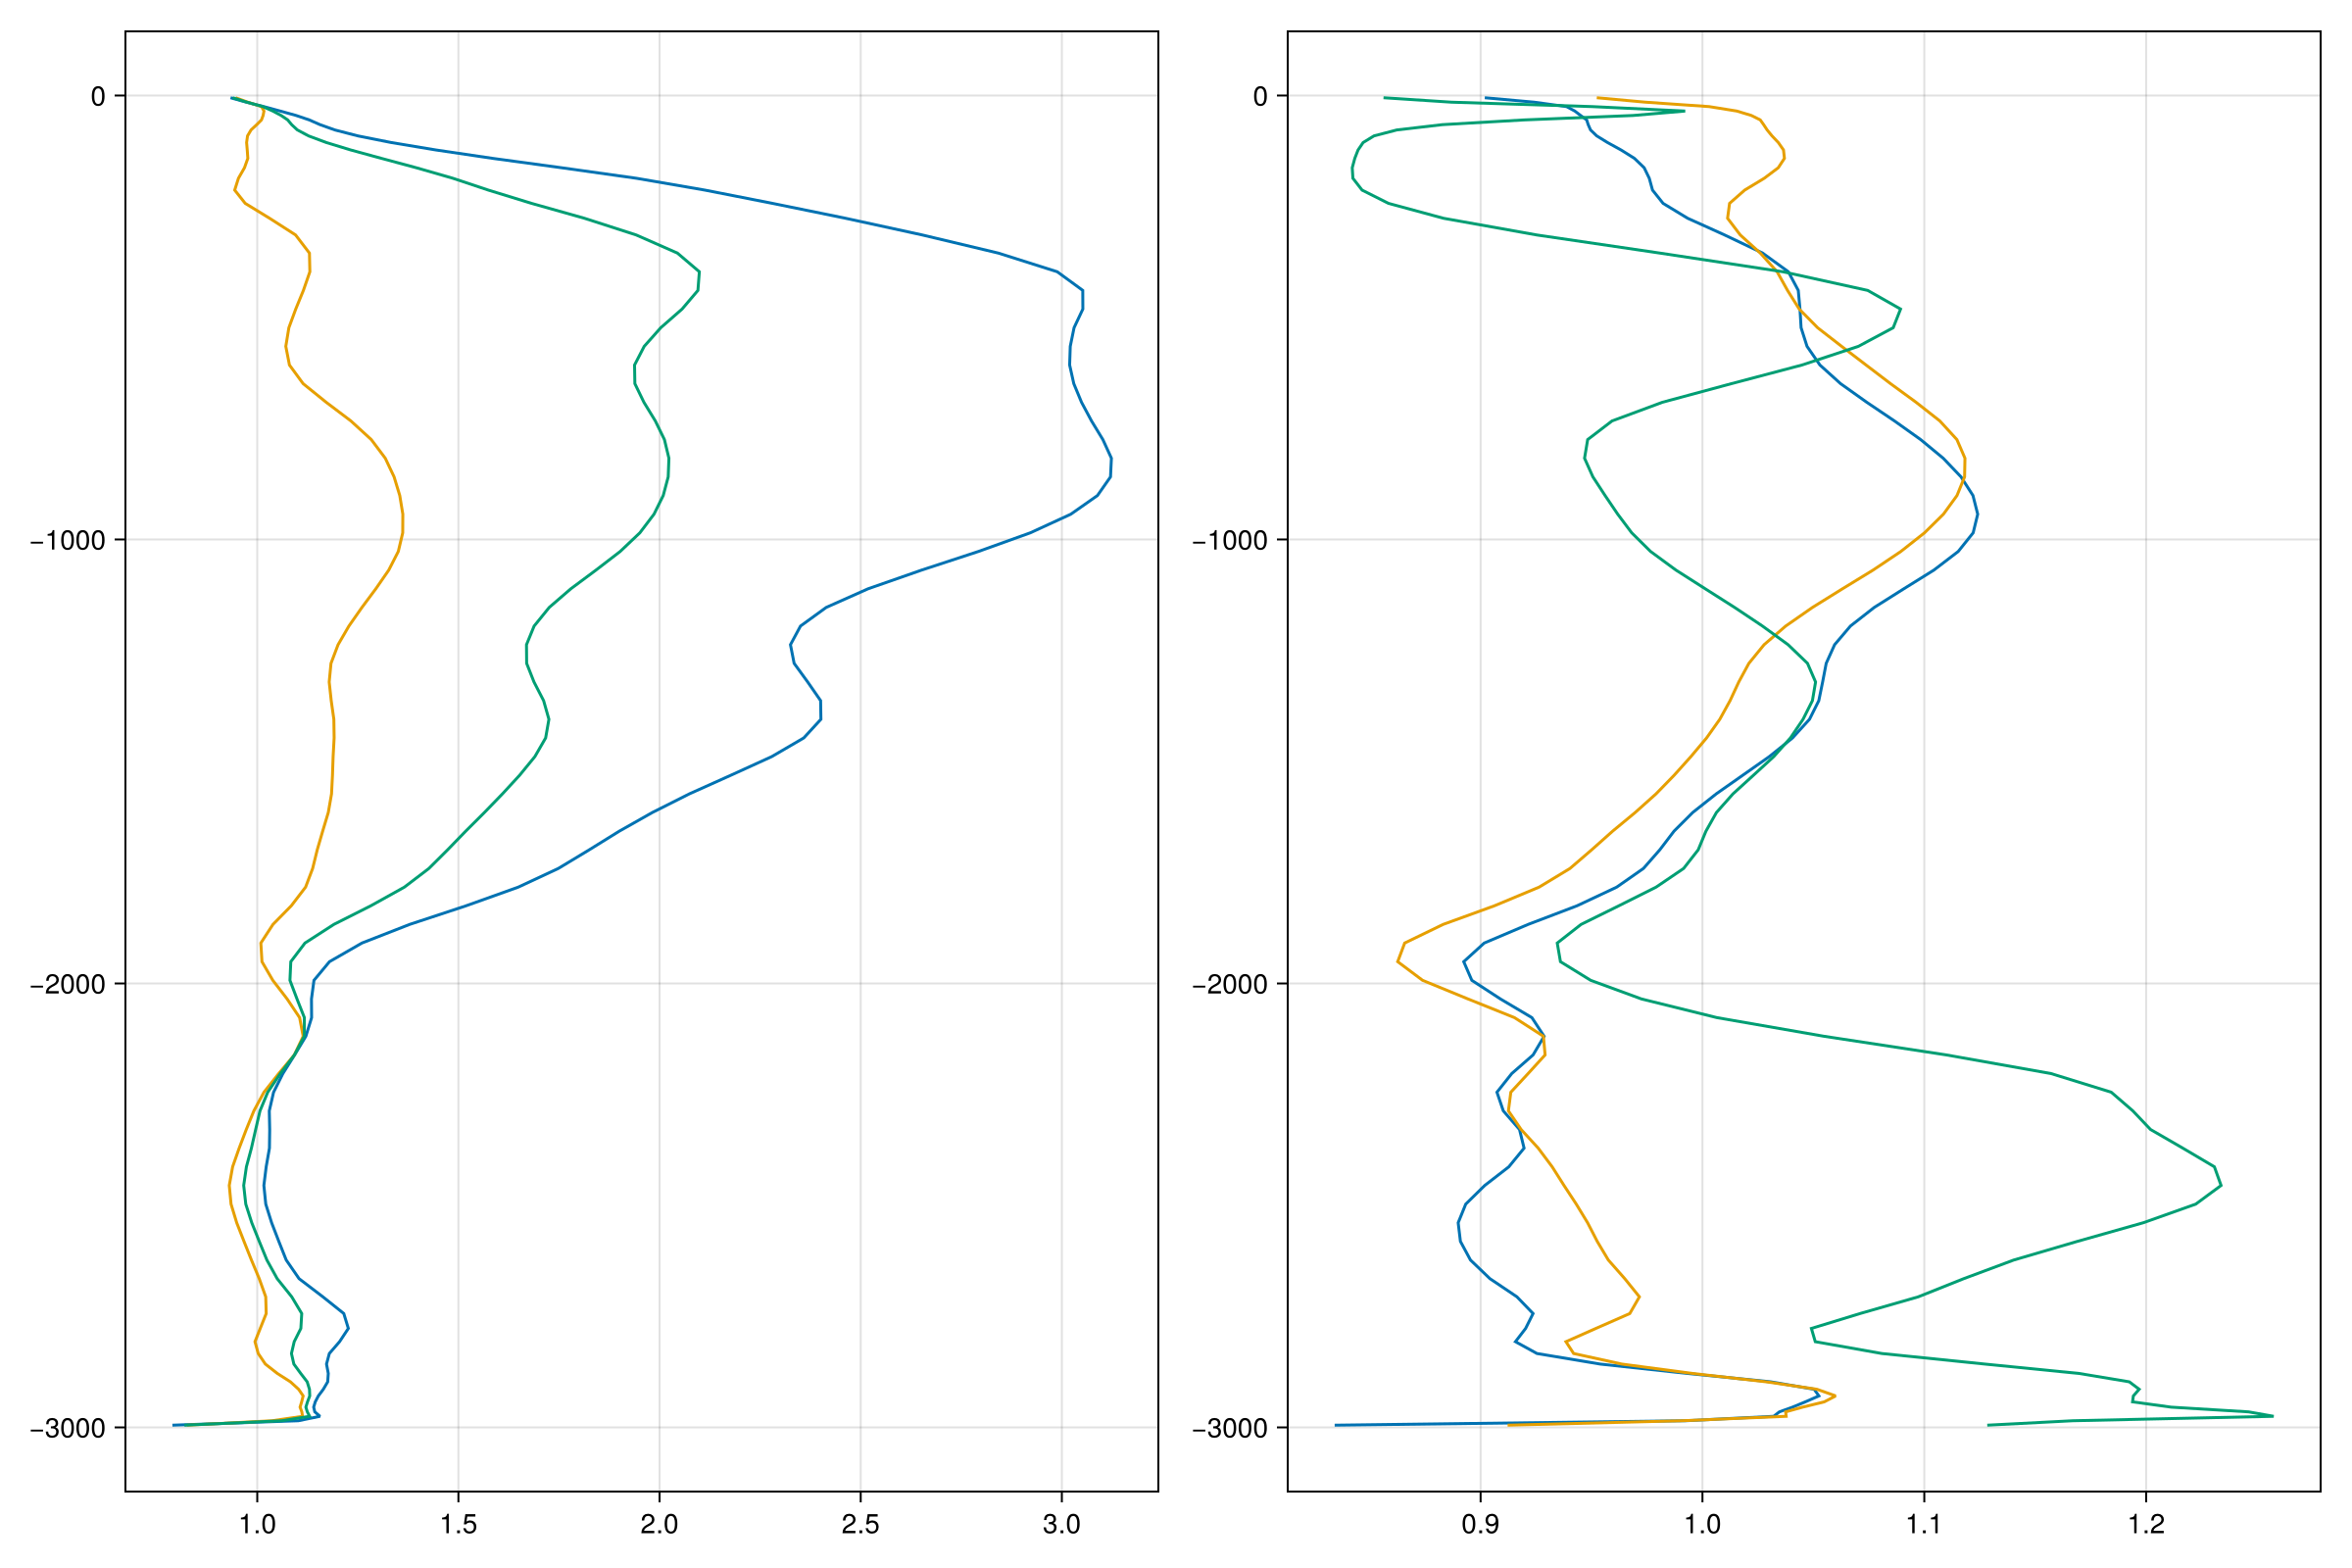

CairoMakie.Screen{IMAGE}


In [11]:
fig = Figure(size = (1200, 800))
ax = Axis(fig[1, 1])
lines!(ax, abs(mean(dawCA.Abx[end], dims=2)) / abs(mean(drwCA.Abx[end], dims=2)))
lines!(ax, abs(mean(dawCA.Aby[end], dims=2)) / abs(mean(drwCA.Aby[end], dims=2)))
lines!(ax, abs(mean(dawCA.Aby[end] + dawCA.Abx[end], dims=2)) / abs(mean(drwCA.Aby[end] + drwCA.Abx[end], dims=2)))

ax = Axis(fig[1, 2])
lines!(ax, abs(mean(dawCA.Gbx[end], dims=2)) / abs(mean(drwCA.Gbx[end], dims=2)))
lines!(ax, abs(mean(dawCA.Gby[end], dims=2)) / abs(mean(drwCA.Gby[end], dims=2)))
lines!(ax, abs(mean(dawCA.Gby[end] + dawCA.Gbx[end] + dawCA.Gbz[end], dims=2)) / abs(mean(drwCA.Gby[end] + drwCA.Gbx[end] + drwCA.Gbz[end], dims=2)))

display(fig)

In [12]:
# Investigate the velocity field now
ua = FieldTimeSeries("../averages_00000.jld2", "u")
ur = FieldTimeSeries("../averages_00010.jld2", "u")
va = FieldTimeSeries("../averages_00000.jld2", "v")
vr = FieldTimeSeries("../averages_00010.jld2", "v")
wa = FieldTimeSeries("../averages_00000.jld2", "w")
wr = FieldTimeSeries("../averages_00010.jld2", "w")
ba = FieldTimeSeries("../averages_00000.jld2", "b")
br = FieldTimeSeries("../averages_00010.jld2", "b")

200×400×90×7 FieldTimeSeries{InMemory} located at (Center, Center, Center) of b at ../averages_00010.jld2
├── grid: 200×400×90 RectilinearGrid{Float64, Periodic, Bounded, Bounded} on CPU with 6×6×6 halo
├── indices: (:, :, :)
├── time_indexing: Linear()
├── backend: InMemory()
├── path: ../averages_00010.jld2
├── name: b
└── data: 212×412×102×7 OffsetArray(::Array{Float64, 4}, -5:206, -5:406, -5:96, 1:7) with eltype Float64 with indices -5:206×-5:406×-5:96×1:7
    └── max=0.0155971, min=-0.000969721, mean=0.00220324

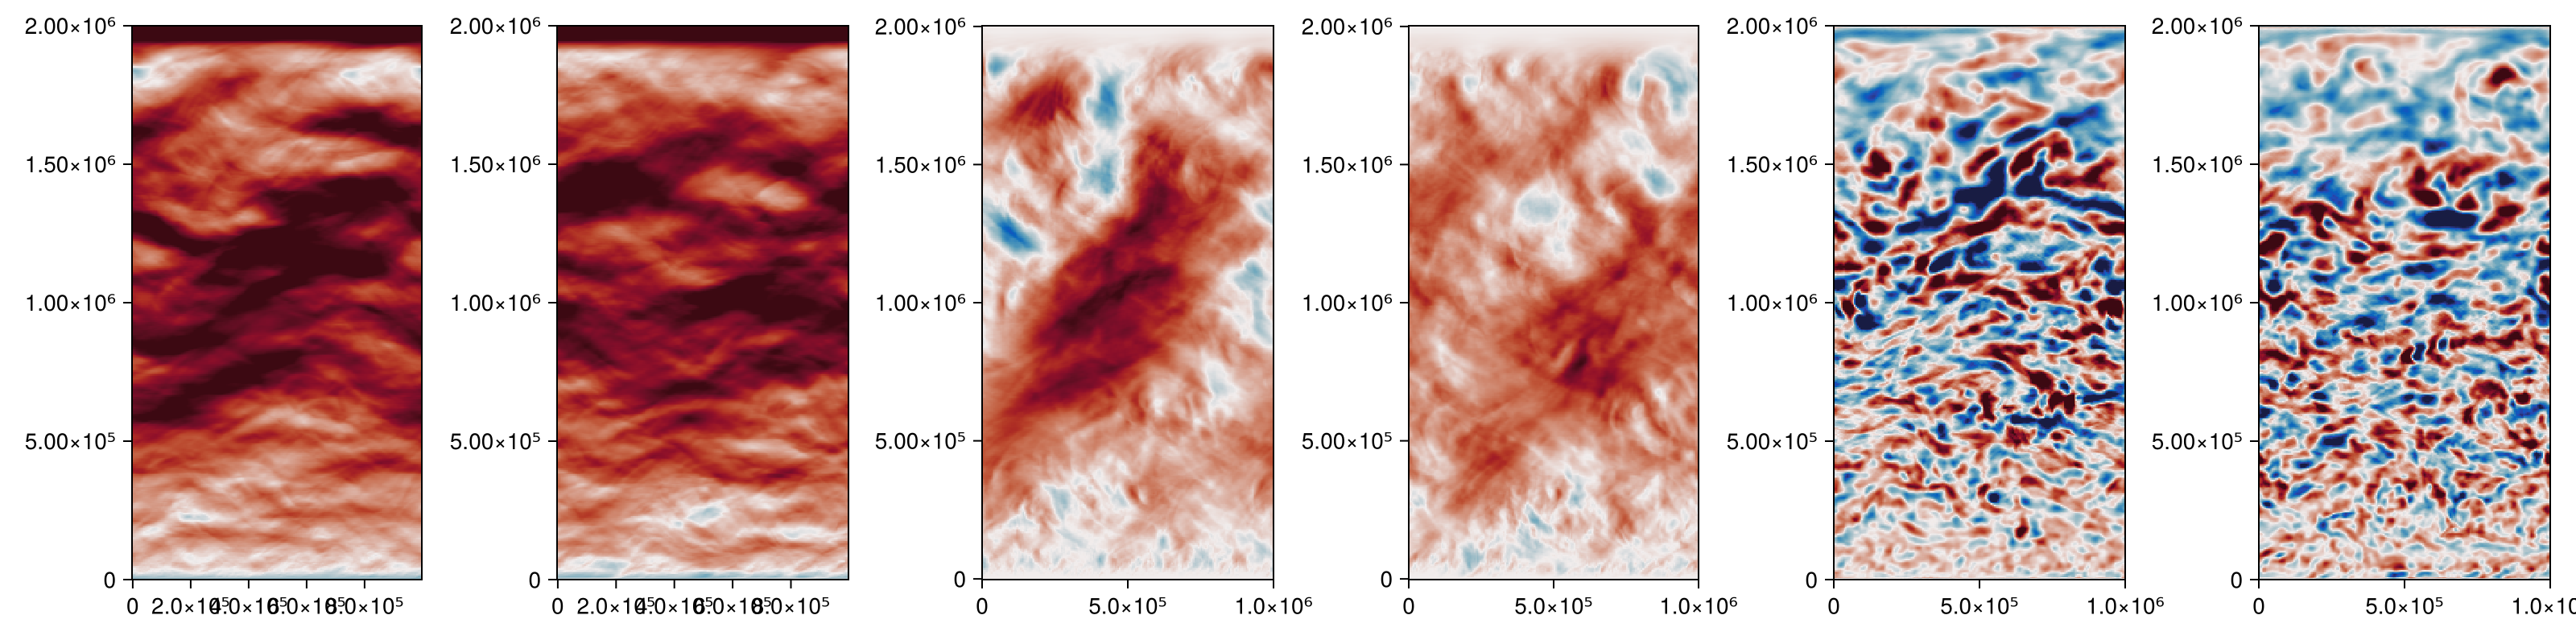

In [14]:
fig = Figure(size = (1600, 400))
ax = Axis(fig[1, 1])
heatmap!(ax, view(ua[end], :, :, 90), colorrange=(-0.3, 0.3), colormap=:balance)
ax = Axis(fig[1, 2])
heatmap!(ax, view(ur[end], :, :, 90), colorrange=(-0.3, 0.3), colormap=:balance)
ax = Axis(fig[1, 3])
heatmap!(ax, view(va[end], :, :, 90), colorrange=(-0.2, 0.2), colormap=:balance)
ax = Axis(fig[1, 4])
heatmap!(ax, view(vr[end], :, :, 90), colorrange=(-0.2, 0.2), colormap=:balance)
ax = Axis(fig[1, 5])
heatmap!(ax, view(wa[end], :, :, 60), colorrange=(-0.2e-4, 0.2e-4), colormap=:balance)
ax = Axis(fig[1, 6])
heatmap!(ax, view(wr[end], :, :, 60), colorrange=(-0.2e-4, 0.2e-4), colormap=:balance)

fig

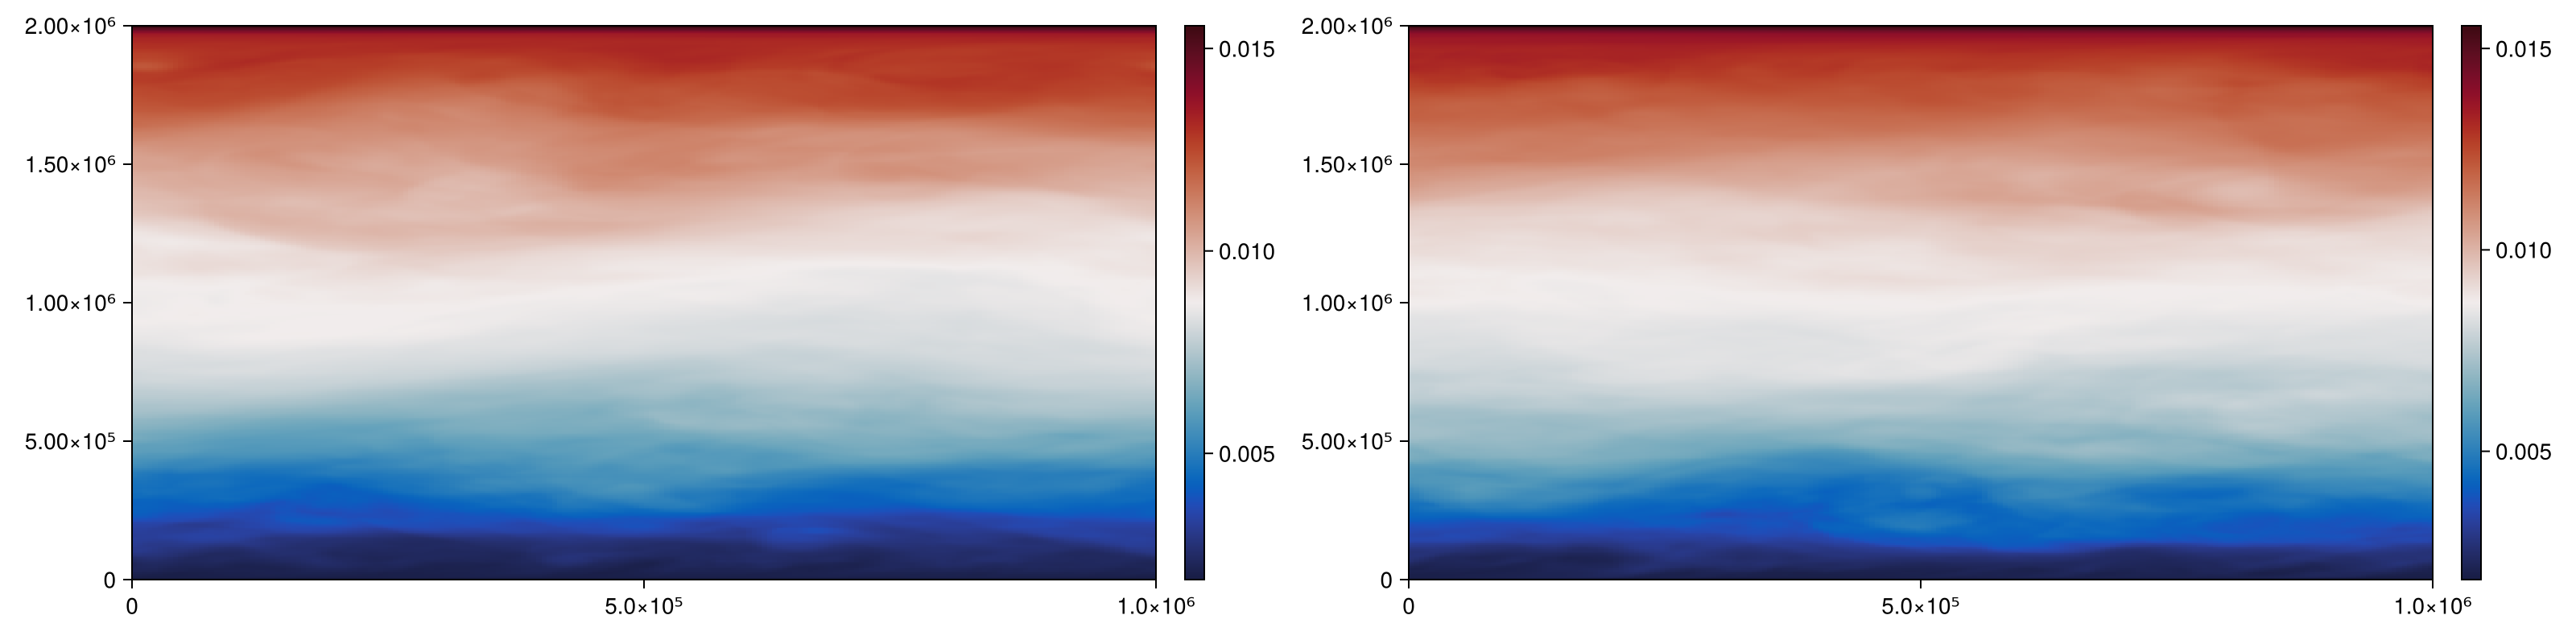

In [15]:
fig = Figure(size = (1600, 400))
ax = Axis(fig[1, 1])
hm = heatmap!(ax, view(ba[end], :, :, 90), colormap=:balance) #, colorrange=(-8e-5, 0))
Colorbar(fig[1, 2], hm)
ax = Axis(fig[1, 3])
hm = heatmap!(ax, view(br[end], :, :, 90), colormap=:balance)#, colorrange=(-8e-5, 0))
Colorbar(fig[1, 4], hm)
fig